In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

In [2]:
def func(x, *args):
    return sum([x ** i * args[i] for i in range(len(args))])


def func1(x, a1, a2, a3, a4, a5):
    return func(x, a1, a2, a3, a4, a5)


def func2(x, a1, a2, a3, a4):
    return func(x, a1, a2, a3, a4)


def func3(x, a1, a2, a3):
    return func(x, a1, a2, a3)

In [3]:
def curve_fit_lines(df, f=func1):
    lines = []
    popts = []
    for ix, line in df.groupby("line_id"):
        phi = line["phi"].iloc[0]
        X, Y = line["x"].values, line["y"].values
        popt, _ = curve_fit(f, Y, X)
        popts.append(popt)
        y = np.arange(Y[0], Y[-1], 0.001)
        x = np.array([f(y_i, *popt) for y_i in y])
        lines.extend([(x_i, y_i, phi, ix) for (x_i, y_i) in zip(x, y)])
    return pd.DataFrame(lines, columns=["x", "y", "phi", "line_id"])

In [4]:
def dot(vec1, vec2):
    return vec1[0] * vec2[0] + vec1[1] * vec2[1]

def get_angle(p11, p12, p21, p22):
    vec1 = (p12[0] - p11[0], p12[1] - p11[1])
    vec2 = (p22[0] - p21[0], p22[1] - p21[1])
    d12 = dot(vec1, vec2)
    l1, l2 = dot(vec1, vec1) ** 0.5, dot(vec2, vec2) ** 0.5
    alpha = np.arccos(d12 / l1 / l2)
    if alpha - np.pi > 0:
        return 2 * np.pi - alpha
    return alpha


In [5]:
def find_force_lines(x_start, y_start, lines, start_line, end_line, access_value=0.001,
                     add_start_point=True, direction=-1, exclude_lines=[], curve_fit_flag=False):
    if add_start_point:
        points = [(x_start, y_start)]
    else:
        points = []
    to_iter = [i for i in lines[start_line - 1:end_line] if i[0] not in exclude_lines]
    prev_phi = to_iter[::direction][0][1].iloc[0]["phi"]
    E_max = -1
    E_max_points = None
    for _, line in to_iter[::direction]:
        for i in range(1, len(line) - 1):
            left = (line.iloc[i - 1, 0], line.iloc[i - 1, 1])
            mid = (line.iloc[i, 0], line.iloc[i, 1])
            right = (line.iloc[i + 1, 0], line.iloc[i + 1, 1])
            angle = get_angle((x_start, y_start), mid, left, right)
            if abs(angle - np.pi / 2) <= access_value:
                # считаем E
                dist = np.sqrt((x_start  - mid[0]) ** 2 + (y_start - mid[1]) ** 2)
                E = abs(prev_phi - line.iloc[0]["phi"]) / (dist / 100)
                if E > E_max:
                    E_max = E
                    E_max_points = ((x_start, y_start, prev_phi), (mid[0], mid[1], line["phi"]))
                ###
                x_start, y_start = mid
                prev_phi = line.iloc[0]["phi"]
                points.append((x_start, y_start))
                break
    points = pd.DataFrame(points, columns=["x", "y"])
    if not curve_fit_flag:
        return points    
    popt, _ = curve_fit(func2, points["x"], points["y"])
    X = np.arange(points.iloc[0, 0], points.iloc[-1, 0], direction * 0.001)
    Y = np.array([func2(x_i, *popt) for x_i in X])
    return pd.DataFrame({"x": X, "y": Y}), (E_max, E_max_points)


In [6]:
def draw_arrows(axes, force_line, num_of_arrows=3, direction=-1):
    v = len(force_line) // num_of_arrows
    ix = np.array([i * v for i in range(1, num_of_arrows + 1)])
    arrows_starts = force_line.iloc[ix - 2]
    arrows_ends = force_line.iloc[ix - 1]
    for i in range(num_of_arrows):
        x, y = arrows_starts.iloc[i]["x"], arrows_starts.iloc[i]["y"]
        dx, dy = arrows_ends.iloc[i]["x"] - x, arrows_ends.iloc[i]["y"] - y
        axes.arrow(x, y, -direction * dx, -direction * dy, shape='full', lw=0, length_includes_head=True, head_width=0.3,
                    color="blue")

In [7]:
def get_random_line(axes, lines, direction=-1, num_of_arrows=3, left_bound=0, right_bound=1000,
                    exclude_lines=[]):
    line_x = []
    line_y = []
    for i in lines:
        if i[0] in exclude_lines:
            continue
        ix = np.random.randint(left_bound, right_bound)
        point = i[1].reset_index().iloc[np.random.randint(left_bound, right_bound)]
        line_x.append(point["x"])
        line_y.append(point["y"])
    popt, _ = curve_fit(func1, line_x, line_y)
    x = np.arange(line_x[0], line_x[-1], 0.001)
    y = np.array([func1(x_i, *popt) for x_i in x])
    axes.plot(x, y, color="blue", linewidth=3)
    draw_arrows(axes, pd.DataFrame({"x": x, "y": y}), direction=direction, num_of_arrows=num_of_arrows)

### Задание1

In [180]:
df = pd.read_csv("lab3.01_task1.csv")
points = curve_fit_lines(df)
points["line_id"] += 1

vline = np.arange(2, 18, 0.001)
points = pd.concat([points, pd.DataFrame(
    {"y": vline, "x": [1] * len(vline), "phi": [0] * len(vline),
     "line_id": [1] * len(vline)})], ignore_index=True)

lines = sorted(points.groupby("line_id"))

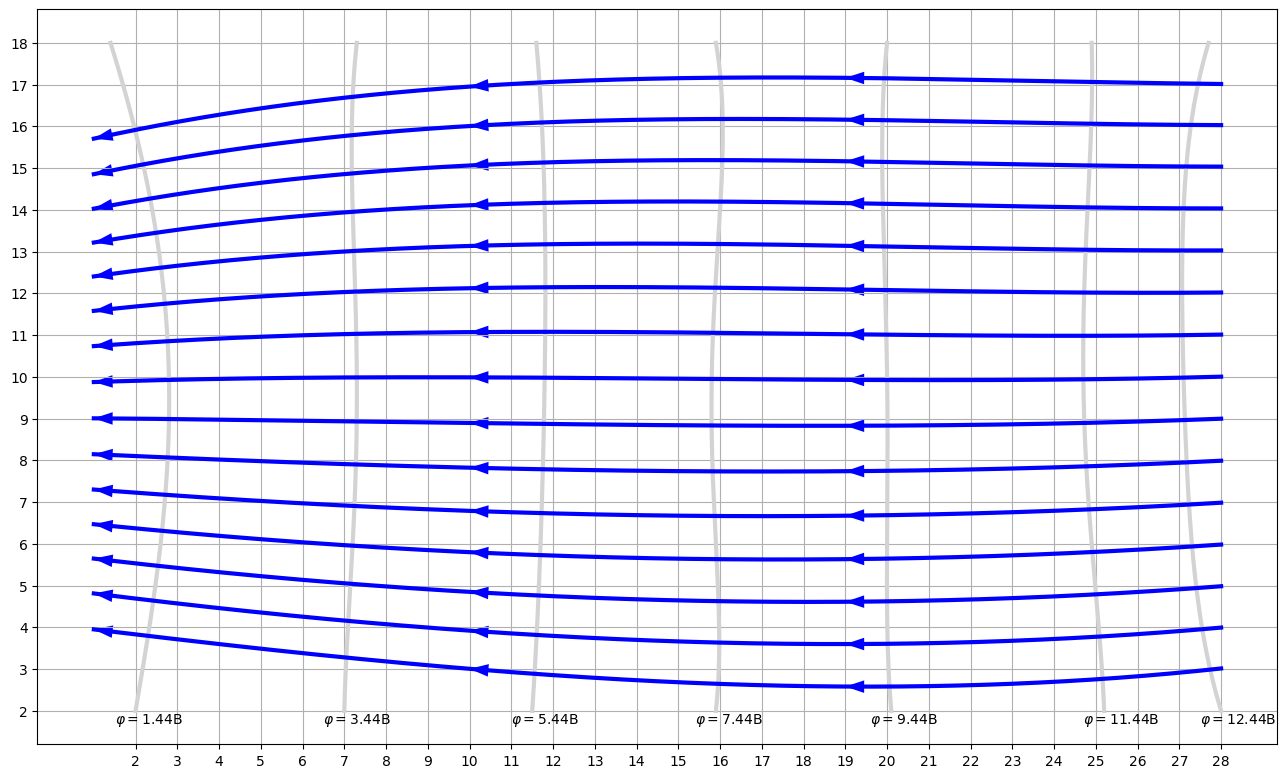

In [182]:
figure, axes = plt.subplots(figsize=(16, 10))
axes.set_aspect(1)
axes.set_xticks(range(2, 29))
axes.set_yticks(range(2, 19))

for _, line in lines:
    if line.iloc[0]["line_id"] in (1,):
        continue
    phi = line['phi'].iloc[0]
    axes.plot(line["x"], line["y"], linewidth=3, color="lightgrey", label=rf"$\varphi={phi}$" + " В")
    axes.text(line.iloc[0]["x"] - 0.5, line.iloc[0]["y"] - 0.3, rf"$\varphi={phi}$" + "В",
                    fontsize="medium")

axes.grid()


for y in range(3, 18):
    force_line, E = find_force_lines(28, y, lines, 1, 7, access_value=0.001, curve_fit_flag=True)
    axes.plot(force_line["x"], force_line["y"], color="blue", linewidth=3)
    draw_arrows(axes, force_line)

### Задание 2

In [8]:
df = pd.read_csv("lab3.01_task2.csv")
points = curve_fit_lines(df, f=func1)
theta = np.linspace(0, 2 * np.pi, 75000)
radius = 6
x_circle = radius * np.cos(theta) + 15
y_circle = radius * np.sin(theta) + 10
circle = pd.DataFrame({"x": x_circle, "y": y_circle, "phi": [6.76] * len(x_circle), "line_id": 6})
hc1 = circle[circle["x"] < 15]
hc2 = circle[circle["x"] > 15]
hc2["line_id"] += 1

line_6_start = points[points["line_id"] == 6].index[0]
points.iloc[line_6_start:, -1] += 2

points = pd.concat([pd.concat([points, hc1], ignore_index=True), hc2], ignore_index=True)

lines = sorted(points.groupby("line_id"), key=lambda x: x[0])

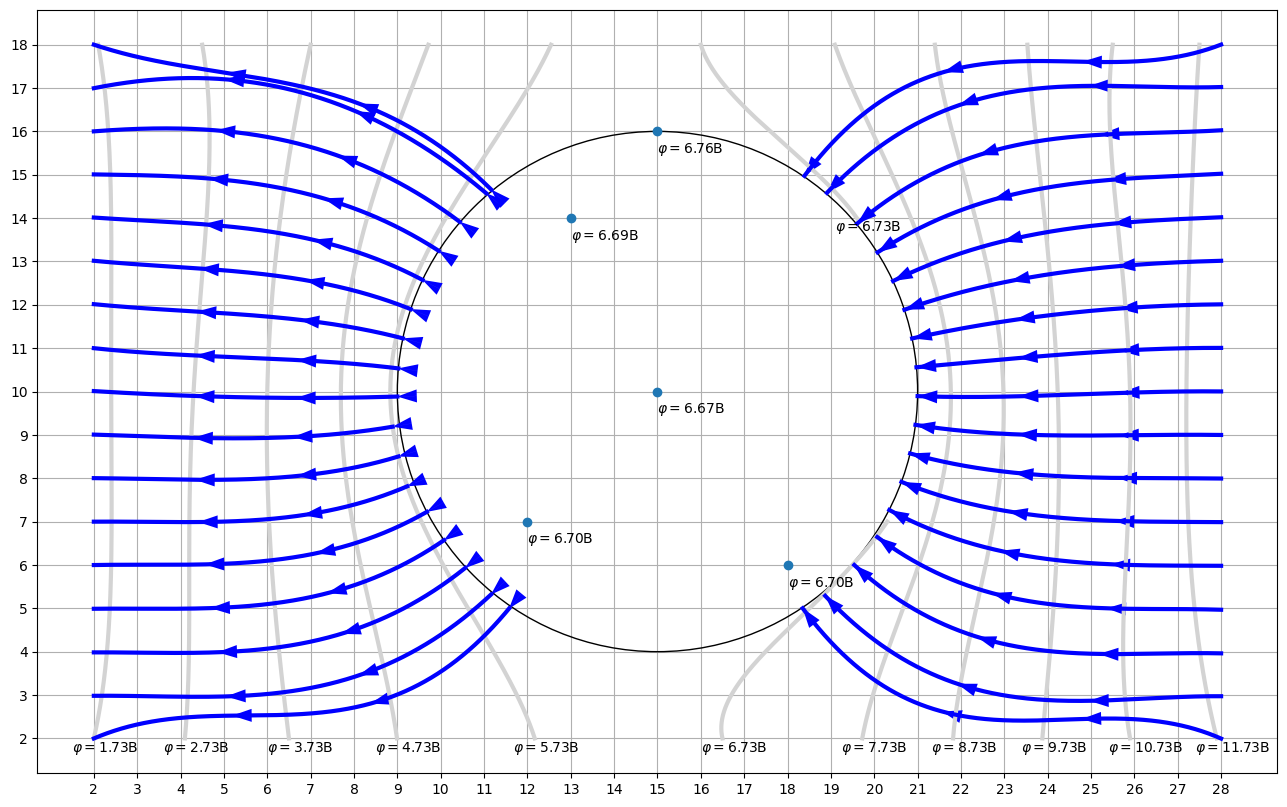

In [10]:
figure, axes = plt.subplots(figsize=(16, 10))
axes.set_xticks(range(2, 29))
axes.set_yticks(range(2, 19))
axes.set_aspect(1)
axes.add_artist(plt.Circle((15, 10), 6, fill=None))
axes.set_axisbelow(True)

for _, line in lines:
    if line.iloc[0]["line_id"] in (6, 7):
        continue
    phi = line['phi'].iloc[0]
    axes.plot(line["x"], line["y"], linewidth=3, color="lightgrey", label=rf"$\varphi={phi}$" + " В")
    axes.text(line.iloc[0]["x"] - 0.5, line.iloc[0]["y"] - 0.3, rf"$\varphi={phi}$" + "В",
                    fontsize="medium")


axes.scatter([12, 13, 15, 15, 18], [7, 14, 10, 16, 6])
axes.text(12, 6.5, rf"$\varphi=6.70$" + "В", fontsize="medium")
axes.text(13, 13.5, rf"$\varphi=6.69$" + "В", fontsize="medium")
axes.text(15, 9.5, rf"$\varphi=6.67$" + "В", fontsize="medium")
axes.text(15, 15.5, rf"$\varphi=6.76$" + "В", fontsize="medium")
axes.text(18, 5.5, rf"$\varphi=6.70$" + "В", fontsize="medium")

axes.grid()

# get_random_line(axes, lines, 1, 3, 0, 500, exclude_lines=[6, 7, 9])
# get_random_line(axes, lines, 1, 3, 15500, 16000, exclude_lines=[6, 7, 8, 9])

for y in range(2, 19):
    force_line, E1 = find_force_lines(28, y, lines, 7, 14, access_value=0.001, curve_fit_flag=True)
    axes.plot(force_line["x"], force_line["y"], color="blue", linewidth=3)
    draw_arrows(axes, force_line)
for y in range(2, 19):
    force_line, E2 = find_force_lines(2, y, lines, 1, 6, access_value=0.001, direction=1, curve_fit_flag=True)
    axes.plot(force_line["x"], force_line["y"], color="blue", linewidth=3)
    draw_arrows(axes, force_line, direction=1)

In [121]:
E1

(67.7296168826124,
 ((20.08002375982309, 15.71199999999849, 7.73),
  (19.021208349336035,
   14.682999999999621,
   85000    6.73
   85001    6.73
   85002    6.73
   85003    6.73
   85004    6.73
            ... 
   88995    6.73
   88996    6.73
   88997    6.73
   88998    6.73
   88999    6.73
   Name: phi, Length: 4000, dtype: float64)))

In [122]:
E2

(187.15719790459733,
 ((10.688134226867383, 14.930999999998576, 5.73),
  (11.050499616354273,
   14.516796067964798,
   169000    6.76
   169001    6.76
   169002    6.76
   169003    6.76
   169004    6.76
             ... 
   206495    6.76
   206496    6.76
   206497    6.76
   206498    6.76
   206499    6.76
   Name: phi, Length: 37500, dtype: float64)))

In [123]:
E_max, (p1, p2) = E2

In [125]:
np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) / 100

0.0055033950685938245

### Задание 5

In [150]:
df1 = pd.read_csv("lab3.01_task1.csv")
df2 = pd.read_csv("lab3.01_task2.csv")
p1 = df1[df1["y"] == 10]
p2 = df2[df2["y"] == 10]

In [151]:
reg = LinearRegression().fit(p1["x"].to_numpy().reshape(-1, 1), p1["phi"].to_numpy())
slope1, intercept1 = reg.coef_[0], reg.intercept_

In [152]:
reg = LinearRegression().fit(p2["x"].to_numpy().reshape(-1, 1), p2["phi"].to_numpy())
slope2, intercept2 = reg.coef_[0], reg.intercept_

Text(1, 10, '$E_2=33.94$ В/дел, $\\varphi_2=1.59$ В')

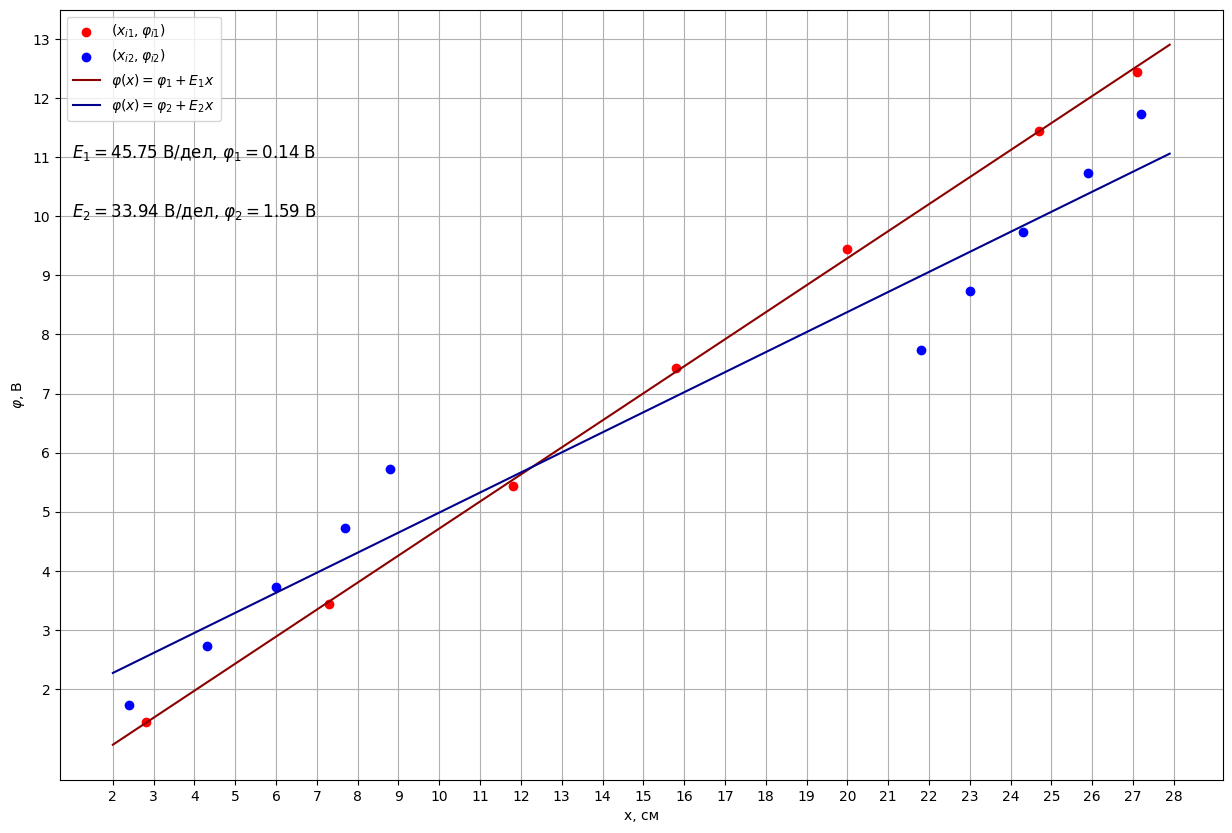

In [170]:
figure, axes = plt.subplots(figsize=(15, 10))
axes.set_xticks(range(2, 29))
axes.set_yticks(range(2, 19))
axes.set_axisbelow(True)
axes.set_xlabel("x, см")
axes.set_ylabel(r"$\varphi$" + ", В")

axes.scatter(p1["x"], p1["phi"], color="red", label=r"$(x_{i1},\varphi_{i1})$")
axes.scatter(p2["x"], p2["phi"], color="blue", label=r"$(x_{i2},\varphi_{i2})$")
axes.plot(np.arange(2, 28, 0.1), np.arange(2, 28, 0.1) * slope1 + intercept1, color="darkred", label=rf"$\varphi(x)=\varphi_{1}+E_{1}x$")
axes.plot(np.arange(2, 28, 0.1), np.arange(2, 28, 0.1) * slope2 + intercept2, color="darkblue", label=rf"$\varphi(x)=\varphi_{2}+E_{2}x$")
axes.grid()
axes.legend()
axes.text(1, 11, rf"$E_1={round(slope1 * 100,  2)}$" + " В/дел, " + rf"$\varphi_1={round(intercept1, 2)}$" + " В", fontsize="large")
axes.text(1, 10, rf"$E_2={round(slope2 * 100,  2)}$" + " В/дел, " + rf"$\varphi_2={round(intercept2, 2)}$" + " В", fontsize="large")

In [171]:
df

,phi,x,y,line_id
0,1.73,2.0,2,1
1,1.73,2.4,6,1
2,1.73,2.4,10,1
3,1.73,2.4,14,1
4,1.73,2.1,18,1
...,...,...,...,...
92,11.73,27.9,2,12
93,11.73,27.3,6,12
94,11.73,27.2,10,12
95,11.73,27.3,14,12


### Measurements

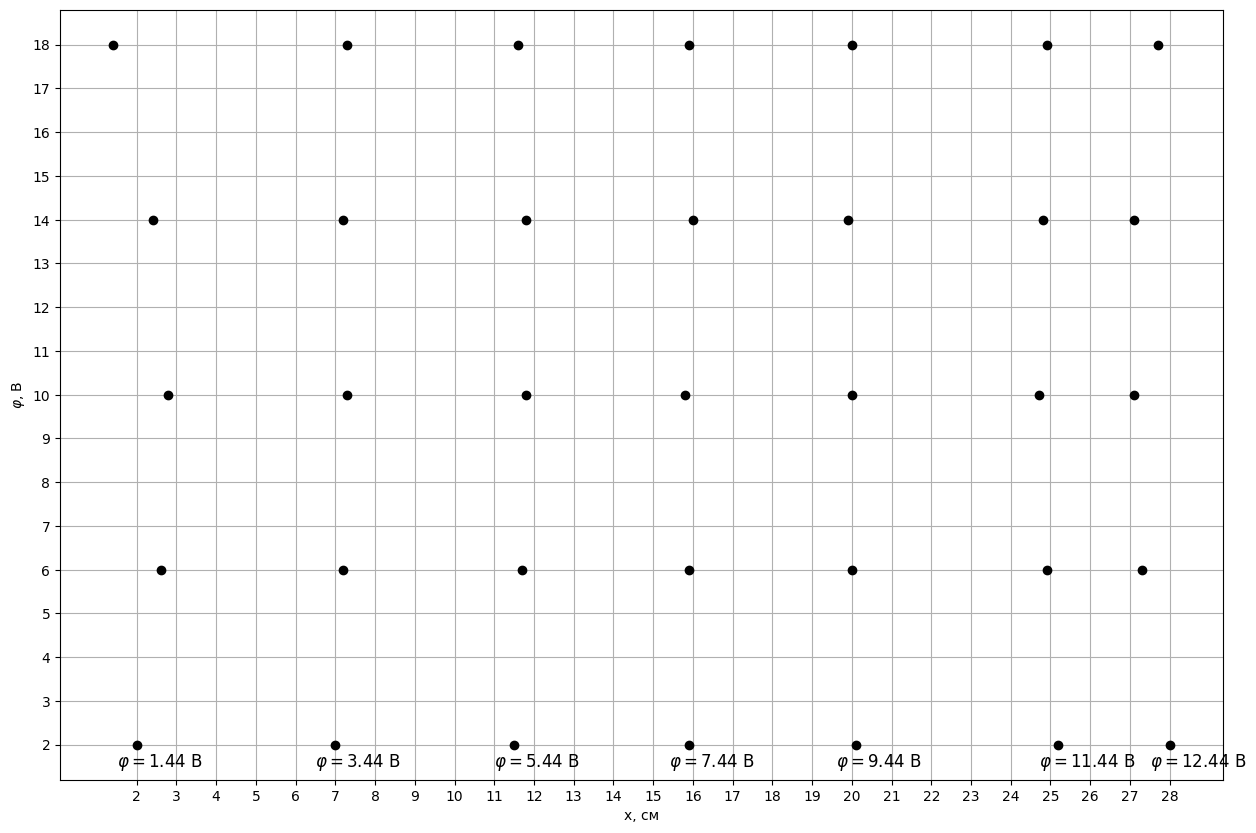

In [177]:
figure, axes = plt.subplots(figsize=(15, 10))
axes.set_xticks(range(2, 29))
axes.set_yticks(range(2, 19))
axes.set_axisbelow(True)
axes.set_xlabel("x, см")
axes.set_ylabel(r"$\varphi$" + ", В")

axes.scatter(df1["x"], df1["y"], color="black")
for i in df1.groupby("line_id"):
    x, y = i[1].iloc[0]["x"], i[1].iloc[0]["y"]
    phi = i[1].iloc[0]["phi"]
    axes.text(x - 0.5, y - 0.5, rf"$\varphi={phi}$" + " В", fontsize="large")
axes.grid()

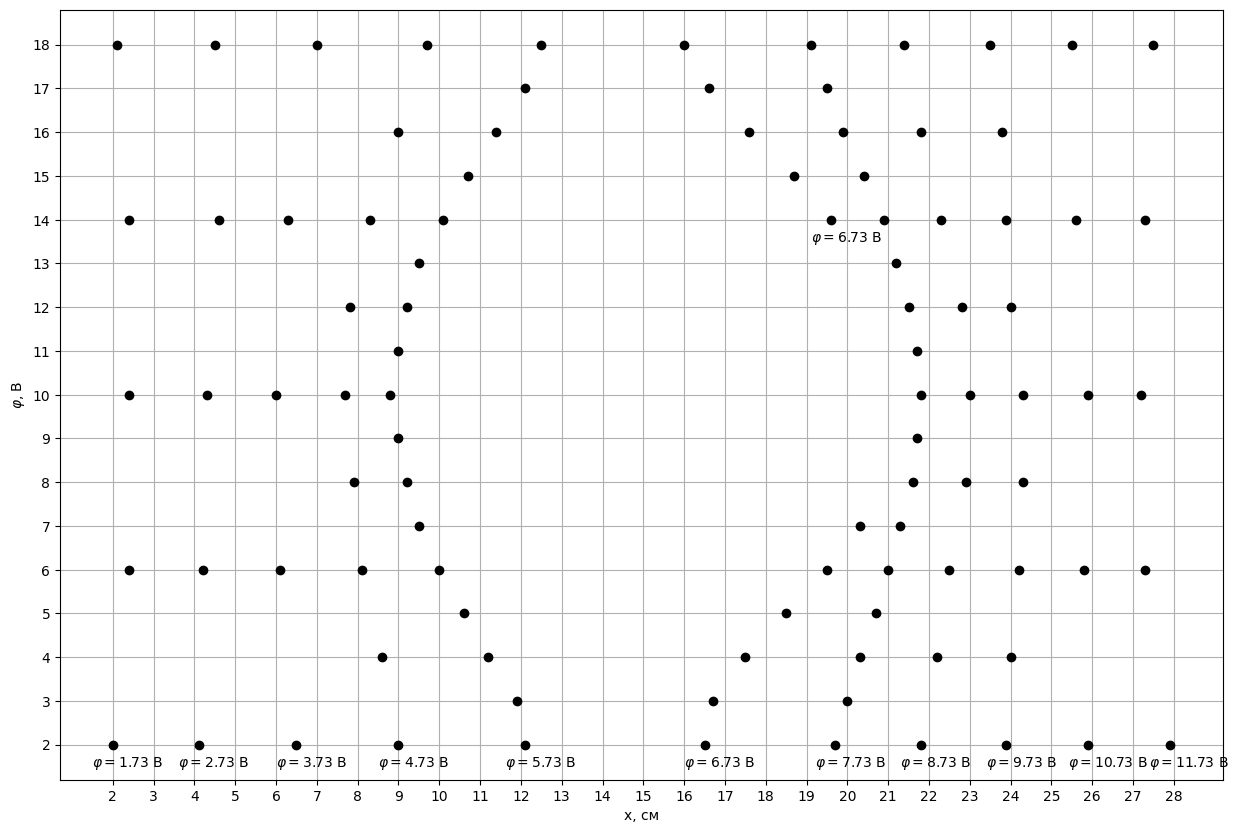

In [179]:
figure, axes = plt.subplots(figsize=(15, 10))
axes.set_xticks(range(2, 29))
axes.set_yticks(range(2, 19))
axes.set_axisbelow(True)
axes.set_xlabel("x, см")
axes.set_ylabel(r"$\varphi$" + ", В")

axes.scatter(df2["x"], df2["y"], color="black")
for i in df2.groupby("line_id"):
    x, y = i[1].iloc[0]["x"], i[1].iloc[0]["y"]
    phi = i[1].iloc[0]["phi"]
    axes.text(x - 0.5, y - 0.5, rf"$\varphi={phi}$" + " В", fontsize="medium")
axes.grid()